In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt

DIR_INPUT = '.'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
torch.cuda._lazy_init()

In [3]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
print(train_df.shape)
print(train_df.head())

(147793, 5)
    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1


In [4]:
bboxs = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    train_df[column] = bboxs[:,i]
train_df.drop(columns=['bbox'], inplace=True)

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train_df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:,'source'] = train_df[['image_id','source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index,y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [6]:
df_folds

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3
...,...,...,...,...
ffb445410,57,rres_1,rres_1_3,1
ffbf75e5b,52,arvalis_1,arvalis_1_3,1
ffbfe7cc0,34,arvalis_1,arvalis_1_2,3


In [7]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        #if self.test or random.random() > 0.5:
        image, boxes = self.load_image_and_boxes(index)
        
        #else:
        #    image, boxes = self.load_cutmix_image_and_boxes(index)
            
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # there is only one class
        records = self.df[self.df['image_id'] == image_id]
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
                
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                
            #    print("Len sample bboxes: ", len(sample['bboxes']))
            #    print("Len labels.shape[0]: ", labels.shape[0])

            #    assert len(sample['bboxes']) == labels.shape[0], 'not equal!'

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0).float()
                    #target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
                
        return image, target, image_id 

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [8]:
def get_train_transforms():
    return A.Compose(
        [
#            A.RandomSunFlare(p=0.2), 
 #           A.RandomFog(p=0.2), 
     #       A.Rotate(p=0.4, limit=90),
     #       A.RandomSnow(p=0.2),
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
 #           A.OneOf([
 #               A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
 #                                    val_shift_limit=0.2, p=0.9),
   #             A.RandomBrightnessContrast(brightness_limit=0.2, 
   #                                        contrast_limit=0.2, p=0.9),
    #        ],p=0.9),
    #        A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1.0),
     #       A.Cutout(num_holes=5, max_h_size=5, max_w_size=5, fill_value=0, p=0.2),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [9]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
fold_number = 0

train_dataset = WheatDataset(image_ids=df_folds[df_folds['fold']!=fold_number].index.values, 
                             dataframe=train_df, 
                             transforms=get_train_transforms(),
                             test = False)

valid_dataset = WheatDataset(image_ids=df_folds[df_folds['fold']==fold_number].index.values, 
                             dataframe=train_df, 
                             transforms=get_valid_transforms(),
                             test = True)

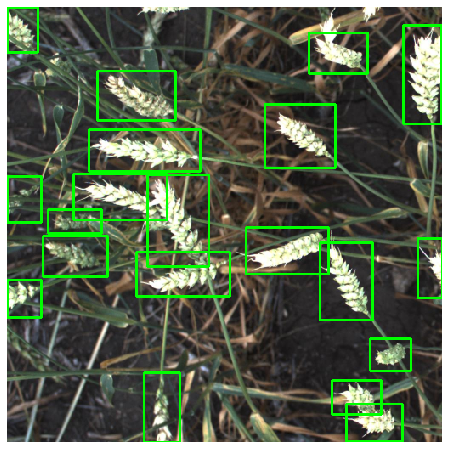

In [11]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))



# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [13]:
backbone = resnet_fpn_backbone('resnet101', pretrained=True)
backbone.out_channels = 256

#anchor_generator = AnchorGenerator(sizes=((32,64,128),),
#                 aspect_ratios=((0.5, 1.0, 2.0),))

#roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                output_size=7,
#                                                sampling_ratio=2)

model = FasterRCNN(backbone, num_classes=2)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [14]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [16]:
WEIGHTS_FILE = 'model/fasterrcnn_resnet101_28wAnno.pth'
model.load_state_dict(torch.load(WEIGHTS_FILE))

<All keys matched successfully>

In [17]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [18]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

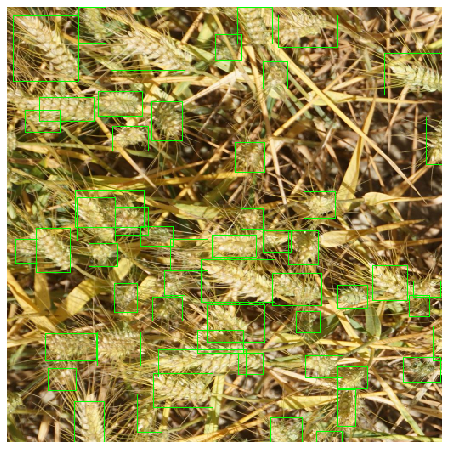

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 1, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [20]:
del images, 
del targets
del image_ids

In [21]:
torch.cuda.empty_cache()

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=0.0001)
optimizer = torch.optim.SGD(params, lr=0.02, momentum=0.9, weight_decay=0.0001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)


num_epochs = 5

In [23]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    print(f"Epoch #{epoch}")
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
            
        itr += 1

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0


Iteration #50 loss: 0.7081438899040222
Iteration #100 loss: 0.790712296962738
Iteration #150 loss: 0.8647700548171997
Iteration #200 loss: 0.6360254287719727
Iteration #250 loss: 0.6058046221733093
Iteration #300 loss: 0.8426127433776855
Iteration #350 loss: 0.7143639326095581
Iteration #400 loss: 0.7395486831665039
Iteration #450 loss: 0.7767650485038757
Epoch #0 loss: 0.6871045609977511
Epoch #1
Iteration #500 loss: 0.504089891910553
Iteration #550 loss: 0.6731933355331421
Iteration #600 loss: 0.6832691431045532
Iteration #650 loss: 0.6246137022972107
Iteration #700 loss: 0.5464762449264526
Iteration #750 loss: 0.6191306114196777
Iteration #800 loss: 0.62555992603302
Iteration #850 loss: 0.7259955406188965
Iteration #900 loss: 0.7815256118774414
Epoch #1 loss: 0.6400112444162369
Epoch #2
Iteration #950 loss: 0.4512326121330261
Iteration #1000 loss: 0.6797577738761902
Iteration #1050 loss: 0.6920448541641235
Iteration #1100 loss: 0.602954089641571
Iteration #1150 loss: 0.5006867051124

In [24]:
images, targets, image_ids = next(iter(valid_data_loader))


In [25]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


In [26]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [27]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


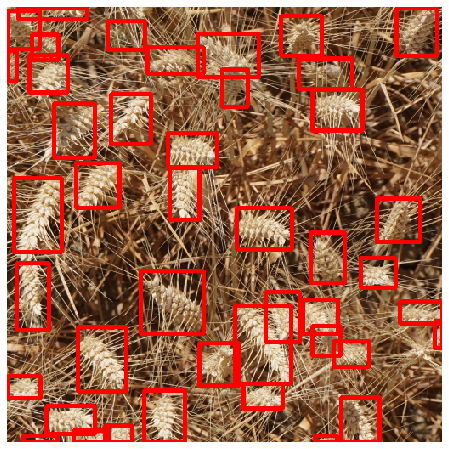

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)


In [29]:
torch.save(model.state_dict(), 'model/fasterrcnn_resnet101_33wAnno.pth')